# Modelo con función de pérdida ponderada

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import os
from os import listdir
from os.path import isfile, join

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [2]:
# Resized images directory
dir_2019_images = "/kaggle/input/resizedsiimisic/train_resized/"

# CSV file
train_df = pd.read_csv('/kaggle/input/resizedsiimisic/train.csv')

In [3]:
train_df.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0000000.jpg,female,55.0,anterior torso,0.0
1,ISIC_0000001.jpg,female,30.0,anterior torso,0.0
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0


In [4]:
print("Train shape:", train_df.shape)

Train shape: (22480, 5)


## <font color=red>2. </font> Función de pérdida ponderada

In [5]:
from sklearn.utils import class_weight as cw

y_train = train_df['target'].to_numpy()
class_weight_ = cw.compute_class_weight('balanced',
                                        np.unique(y_train),
                                        y_train)
print(class_weight_)

[0.61983015 2.58628624]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 1. ... 1. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [6]:
class_weight_ = {0:class_weight_[0], 1:class_weight_[1]}

In [7]:
from collections import Counter
from sklearn.model_selection import train_test_split

X = train_df
y = train_df['target']

In [8]:
# Split into train, validation test and calibration sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)

X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, 
                                                    test_size=0.4,
                                                    stratify=y_test,
                                                    random_state=42)


print("Conjunto de train:", X_train.shape)
print("Conjunto de validacion:", X_val.shape)
print("Conjunto de prueba:", X_test.shape)
print("Conjunto de calibracion:", X_calib.shape)
print("-----------------------")
print('Distribucion de train ->', Counter(y_train))
print('Distribucion de validacion ->', Counter(y_val))
print("Distribucion de prueba ->", Counter(y_test))
print("Distribucion de calibracion ->", Counter(y_calib))

Conjunto de train: (14387, 5)
Conjunto de validacion: (3597, 5)
Conjunto de prueba: (2697, 5)
Conjunto de calibracion: (1799, 5)
-----------------------
Distribucion de train -> Counter({0.0: 11605, 1.0: 2782})
Distribucion de validacion -> Counter({0.0: 2902, 1.0: 695})
Distribucion de prueba -> Counter({0.0: 2176, 1.0: 521})
Distribucion de calibracion -> Counter({0.0: 1451, 1.0: 348})


In [9]:
X_train.to_csv('/kaggle/working/train.csv', index=False)
X_val.to_csv('/kaggle/working/val.csv', index=False)
X_calib.to_csv('/kaggle/working/calib.csv', index=False)
X_test.to_csv('/kaggle/working/test.csv', index=False)

In [10]:
X_train["target"] = X_train['target'].astype(str)
X_val["target"] = X_val['target'].astype(str)
X_calib["target"] = X_calib['target'].astype(str)
X_test["target"] = X_test['target'].astype(str)

## <font color=red>3. </font>Crear y entrenar el modelo

In [11]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

2021-12-02 04:13:22.783824: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [12]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

calib_generator = datagen.flow_from_dataframe(
    dataframe=X_calib,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_CALIB=calib_generator.n//calib_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 14387 validated image filenames belonging to 2 classes.
Found 3597 validated image filenames belonging to 2 classes.
Found 1799 validated image filenames belonging to 2 classes.
Found 2697 validated image filenames belonging to 2 classes.


In [14]:
encoder = DenseNet121(input_shape=(None,None,3), 
                      include_top=False, 
                      weights='imagenet')

In [15]:
inputs = Input(shape=(None, None, 3))
x = encoder(inputs, training=False)
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model_weighted_loss = Model(inputs=inputs, outputs=predictions)

In [16]:
model_weighted_loss.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [17]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      AUC(name='auc')
]

In [18]:
checkpoint_filepath = '/kaggle/working/weighted_model.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_auc',
                                            mode='max',
                                            verbose=1,
                                            save_best_only=True)

In [19]:
model_weighted_loss.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=METRICS
)

In [21]:
model_weighted_loss.fit(train_generator,  
                        validation_data=valid_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        validation_steps=STEP_SIZE_VALID,
                        class_weight=class_weight_,
                        callbacks=[model_checkpoint_callback],
                        epochs = 100)

Epoch 1/100
449/449 [==============================] - 146s 324ms/step - loss: 0.7666 - tp: 1499.0000 - fp: 5704.0000 - tn: 5875.0000 - fn: 1277.0000 - auc: 0.5254 - val_loss: 0.7117 - val_tp: 694.0000 - val_fp: 2890.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_auc: 0.5000

Epoch 00001: val_auc improved from -inf to 0.50000, saving model to /kaggle/working/weighted_model.h5
Epoch 2/100
449/449 [==============================] - 133s 295ms/step - loss: 0.6946 - tp: 1393.0000 - fp: 5841.0000 - tn: 5739.0000 - fn: 1382.0000 - auc: 0.5014 - val_loss: 0.6689 - val_tp: 211.0000 - val_fp: 469.0000 - val_tn: 2422.0000 - val_fn: 482.0000 - val_auc: 0.6515

Epoch 00002: val_auc improved from 0.50000 to 0.65154, saving model to /kaggle/working/weighted_model.h5
Epoch 3/100
449/449 [==============================] - 131s 293ms/step - loss: 0.6980 - tp: 1402.0000 - fp: 5740.0000 - tn: 5842.0000 - fn: 1371.0000 - auc: 0.5035 - val_loss: 0.6573 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_

## <font color=red>4. </font>Evaluar el modelo

In [22]:
eval_metrics = model_weighted_loss.evaluate(test_generator,
                                            steps=STEP_SIZE_TEST,
                                            return_dict=True,
                                            use_multiprocessing=False,
                                            verbose=1)

84/84 [==============================] - 19s 224ms/step - loss: 0.4912 - tp: 318.0000 - fp: 408.0000 - tn: 1760.0000 - fn: 202.0000 - auc: 0.7976


In [23]:
calib_labels = calib_generator.classes
test_labels = test_generator.classes

predict_calib = model_weighted_loss.predict(calib_generator,
                                            verbose=1)
predict_test = model_weighted_loss.predict(test_generator,
                                           verbose=1)

85/85 [==============================] - 7s 86ms/step


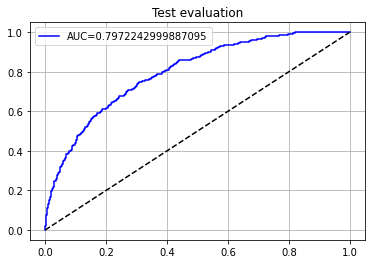

In [24]:
from sklearn import metrics

fpr, tpr, tr = metrics.roc_curve(test_labels, predict_test.ravel())
auc = metrics.roc_auc_score(test_labels, predict_test.ravel())
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation')
plt.grid()
plt.legend(loc='best')
plt.show()

#### Finalmente, se observa la matriz de confusión para el conjunto de prueba y calibración.

In [25]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(test_labels, np.where(np.array(predict_test.ravel()) > 0.5, 1, 0))
cm_test

array([[1767,  409],
       [ 203,  318]])

Test dataset


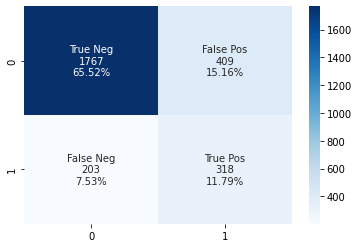

In [26]:
import seaborn as sns

cm = [cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')
print("Test dataset")

In [27]:
cm_calib = confusion_matrix(calib_labels, np.where(np.array(predict_calib.ravel()) > 0.5, 1, 0))
cm_calib

array([[1180,  271],
       [ 129,  219]])

Calibration dataset


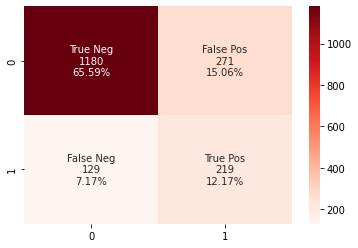

In [28]:
cm = [cm_calib[0][0], cm_calib[0][1], cm_calib[1][0], cm_calib[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Reds')
print("Calibration dataset")

In [35]:
weight_test_predictions = {'Ground Truth': test_labels,
                           'Weighted Classifier prediction': predict_test.ravel().astype(str)}

df_test_predictions = pd.DataFrame(weight_test_predictions)
df_test_predictions.tail(10)

,Ground Truth,Weighted Classifier prediction
2687,1,0.68979675
2688,1,0.32758382
2689,0,0.29353452
2690,0,0.22555995
2691,0,0.47937143
2692,0,0.19716726
2693,0,0.062639244
2694,0,0.32217467
2695,0,0.62787104
2696,0,0.32848173


In [30]:
weight_calib_predictions = {'Ground Truth': calib_labels,
                            'Weighted Classifier prediction': predict_calib.ravel().astype(str)}

df_calib_predictions = pd.DataFrame(weight_calib_predictions)
df_calib_predictions.head(10)

,Ground Truth,Weighted Classifier prediction
0,0,0.44051456
1,0,0.6877817
2,0,0.1157808
3,0,0.038564306
4,0,0.24790537
5,0,0.42891413
6,0,0.32378426
7,0,0.2410134
8,0,0.2906494
9,1,0.99265057


In [31]:
df_calib_predictions.to_csv('/kaggle/working/weight_calib_predictions.csv', index=False)
df_test_predictions.to_csv('/kaggle/working/weight_test_predictions.csv', index=False)